In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

### 1. Bộ dữ liệu ARE Historical Data

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ARE-Historical-Data.csv')
df1=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 4s 44ms/step - loss: 0.0871 - val_loss: 0.3191
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0386 - val_loss: 0.1189
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0143 - val_loss: 0.0703
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0119 - val_loss: 0.0619
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0092 - val_loss: 0.0348
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0060 - val_loss: 0.0172
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 7.4321e-04 - val_loss: 0.0059
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 3.3479e-04 - val_loss: 0.0105
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 3.2443e-04 - val_loss: 0.0

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 1ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [13]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 3.370366174131978
Testing RMSE: 3.508275250314213
Testing MAE: 2.4671355991949717
Validation MAE: 2.6440600112017467
Testing MAPE: 1.497857100849527
Validation MAPE: 1.5939855159952305


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.28731257]
2
1 day input [0.28731257]
1 day output [[0.28631324]]
2 day input [0.28631324]
2 day output [[0.28531167]]
3 day input [0.28531167]
3 day output [[0.28430784]]
4 day input [0.28430784]
4 day output [[0.2833018]]
5 day input [0.2833018]
5 day output [[0.28229365]]
6 day input [0.28229365]
6 day output [[0.28128335]]
7 day input [0.28128335]
7 day output [[0.2802709]]
8 day input [0.2802709]
8 day output [[0.27925634]]
9 day input [0.27925634]
9 day output [[0.27823973]]
10 day input [0.27823973]
10 day output [[0.27722114]]
11 day input [0.27722114]
11 day output [[0.2762005]]
12 day input [0.2762005]
12 day output [[0.27517793]]
13 day input [0.27517793]
13 day output [[0.27415338]]
14 day input [0.27415338]
14 day output [[0.273127]]
15 day input [0.27312699]
15 day output [[0.27209875]]
16 day input [0.27209875]
16 day output [[0.27106866]]
17 day input [0.27106866]
17 day output [[0.2700368]]
18 day input [0.27003679]
18 day output [[0.26900327]]
19 day input [0.269003

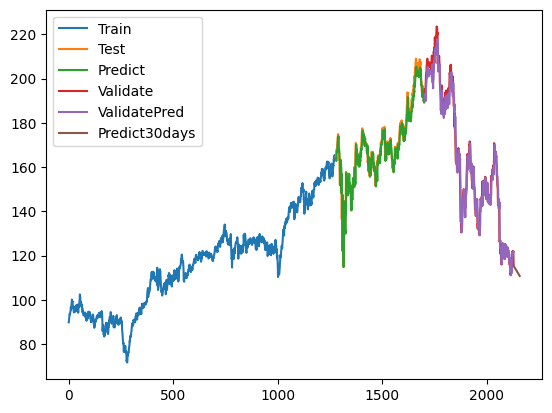

In [15]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

### 2. Bộ dữ liệu ARI Historical Data

In [16]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ARI-Historical-Data.csv')
df1=df.reset_index()['Price']

In [17]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [18]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [19]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [20]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [21]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [22]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [23]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 4s 42ms/step - loss: 0.6860 - val_loss: 0.2075
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4086 - val_loss: 0.0455
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0484 - val_loss: 0.0999
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.0407
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0564
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0509
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0512
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0521
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0498
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0012 - val_loss: 0.0495
Epoch 11

In [24]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 1ms/step


In [25]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [26]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [27]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 0.9944292509489188
Testing RMSE: 1.3080322332690497
Testing MAE: 0.9918964605128509
Validation MAE: 0.8625073118322031
Testing MAPE: 10.88725646502767
Validation MAPE: 7.952950693431078


In [28]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.5206092]
2
1 day input [0.5206092]
1 day output [[0.566595]]
2 day input [0.56659502]
2 day output [[0.60191315]]
3 day input [0.60191315]
3 day output [[0.6299771]]
4 day input [0.62997711]
4 day output [[0.65286845]]
5 day input [0.65286845]
5 day output [[0.6719331]]
6 day input [0.67193311]
6 day output [[0.68808305]]
7 day input [0.68808305]
7 day output [[0.7019586]]
8 day input [0.7019586]
8 day output [[0.7140238]]
9 day input [0.71402383]
9 day output [[0.7246235]]
10 day input [0.7246235]
10 day output [[0.734019]]
11 day input [0.73401898]
11 day output [[0.7424129]]
12 day input [0.74241292]
12 day output [[0.7499644]]
13 day input [0.74996442]
13 day output [[0.75680023]]
14 day input [0.75680023]
14 day output [[0.7630229]]
15 day input [0.7630229]
15 day output [[0.7687162]]
16 day input [0.76871622]
16 day output [[0.7739488]]
17 day input [0.77394879]
17 day output [[0.77877855]]
18 day input [0.77877855]
18 day output [[0.7832537]]
19 day input [0.78325373]
19 day 

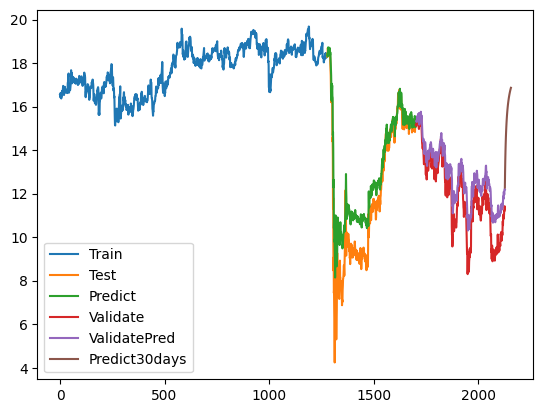

In [29]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

### 3. Bộ dữ liệu MAA Historical Data

In [30]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('MAA-Historical-Data.csv')
df1=df.reset_index()['Price']

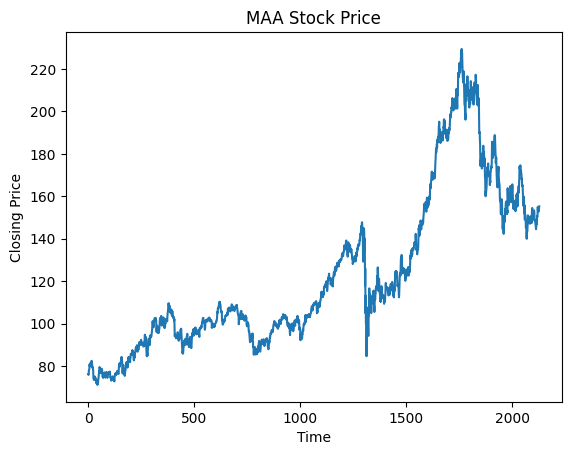

In [31]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df1)
plt.title('MAA Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

In [32]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [33]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [34]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [35]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [36]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [37]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [38]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 4s 41ms/step - loss: 0.0281 - val_loss: 0.1340
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0099 - val_loss: 0.0591
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0076 - val_loss: 0.0725
Epoch 4/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.0526
Epoch 5/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0048 - val_loss: 0.0301
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 3.3633e-04 - val_loss: 0.0058
Epoch 8/100
20/20 [==============================] - 0s 4ms/step - loss: 1.1460e-04 - val_loss: 0.0051
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 8.9508e-05 - val_loss: 0.0027
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 8.4447e-05 - val_loss:

In [39]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

14/14 [==============================] - 0s 1ms/step


In [40]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [41]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [42]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 3.81526650717836
Testing RMSE: 3.077919202010447
Testing MAE: 2.146018209975944
Validation MAE: 2.9540418615004596
Testing MAPE: 1.6241783692670881
Validation MAPE: 1.6012557872855815


In [43]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[426:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=1
i=0
while(i<30):
    
    if(len(temp_input)>1):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.5275873]
2
1 day input [0.52758729]
1 day output [[0.52371746]]
2 day input [0.52371746]
2 day output [[0.51994115]]
3 day input [0.51994115]
3 day output [[0.51625323]]
4 day input [0.51625323]
4 day output [[0.512649]]
5 day input [0.512649]
5 day output [[0.50912416]]
6 day input [0.50912416]
6 day output [[0.5056746]]
7 day input [0.5056746]
7 day output [[0.50229657]]
8 day input [0.50229657]
8 day output [[0.49898636]]
9 day input [0.49898636]
9 day output [[0.49574077]]
10 day input [0.49574077]
10 day output [[0.49255663]]
11 day input [0.49255663]
11 day output [[0.4894309]]
12 day input [0.4894309]
12 day output [[0.4863609]]
13 day input [0.48636091]
13 day output [[0.4833439]]
14 day input [0.4833439]
14 day output [[0.4803776]]
15 day input [0.48037761]
15 day output [[0.47745955]]
16 day input [0.47745955]
16 day output [[0.4745875]]
17 day input [0.4745875]
17 day output [[0.4717595]]
18 day input [0.4717595]
18 day output [[0.46897358]]
19 day input [0.46897358]
19 d

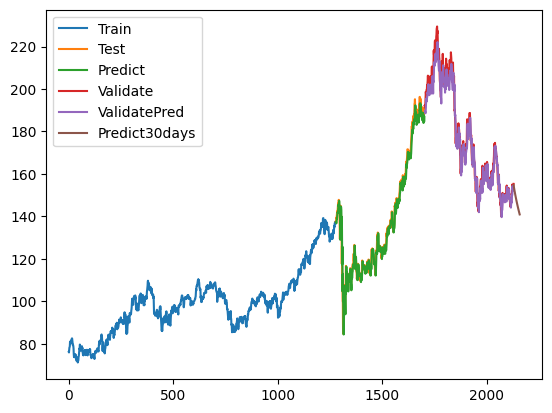

In [44]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+2, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+2, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()